# California Housing Prices

####  Exploratory Data Analysis

##### Import libraries

In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

###### Function for wrangling my data

In [244]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    #remove outlier in median_income "top 10% and bottom 10%"
    low, high= df["median_income"].quantile([0.1,0.9])
    mask_medincom= df['median_income'].between(low, high)
    df = df[mask_medincom]
    
    #remove outlier in median_income "top 20% and bottom 20%"
    low, high= df["housing_median_age"].quantile([0.2,0.8])
    mask_housmedage= df["housing_median_age"].between(low, high)
    df = df[mask_housmedage]
    
     #remove outlier in median_house_value  "top 20% and bottom 20%"
    low, high= df["median_house_value"].quantile([0.2,0.8])
    mask_medhousval= df["median_house_value"].between(low, high)
    df = df[mask_medhousval]
    
    #remove high and low cardinality variables
    df.drop(columns=[
        "population",
        "total_rooms",
        "total_bedrooms",
        "households",
        "housing_median_age",
        "ocean_proximity" 
    ],
        inplace=True
)
    return df


###### check for missing values. There seems not to be any null values

In [221]:
df = wrangle("C:/Users/USER/Downloads/data/housing.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6038 entries, 74 to 20634
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           6038 non-null   float64
 1   latitude            6038 non-null   float64
 2   median_income       6038 non-null   float64
 3   median_house_value  6038 non-null   float64
dtypes: float64(4)
memory usage: 235.9 KB
None


,longitude,latitude,median_income,median_house_value
74,-122.29,37.81,2.4830,137500.0
79,-122.28,37.80,2.0114,131300.0
93,-122.27,37.79,2.6354,187500.0
95,-122.26,37.80,2.0096,130000.0
96,-122.26,37.82,2.8345,183800.0


######  Boxplot for median house value

Text(0.5, 1.0, 'median_house_value distribution')

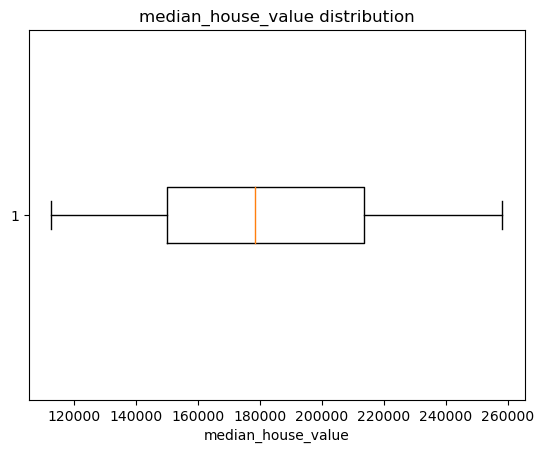

In [180]:
plt.boxplot(df["median_house_value"], vert=False)
plt.xlabel("median_house_value")
plt.title("median_house_value distribution")

######  Ploting the distribution of medium income

Text(0.5, 1.0, 'Medium income distribution')

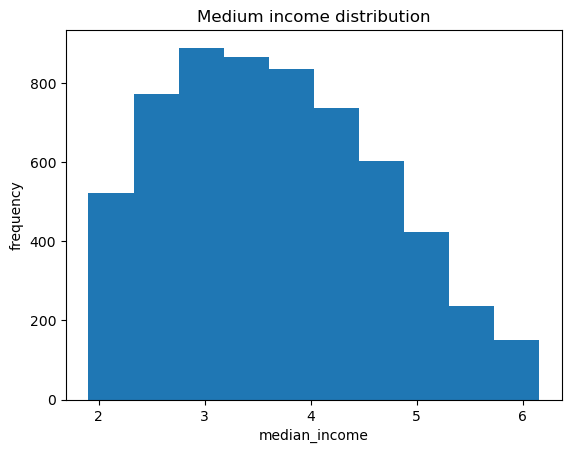

In [181]:
plt.hist(df["median_income"])
plt.xlabel("median_income")
plt.ylabel("frequency")
plt.title("Medium income distribution")

###### Plotting heatmap to check for  features that has no or very low correlation to the median_house_value feature. I decided to drop them before building the model

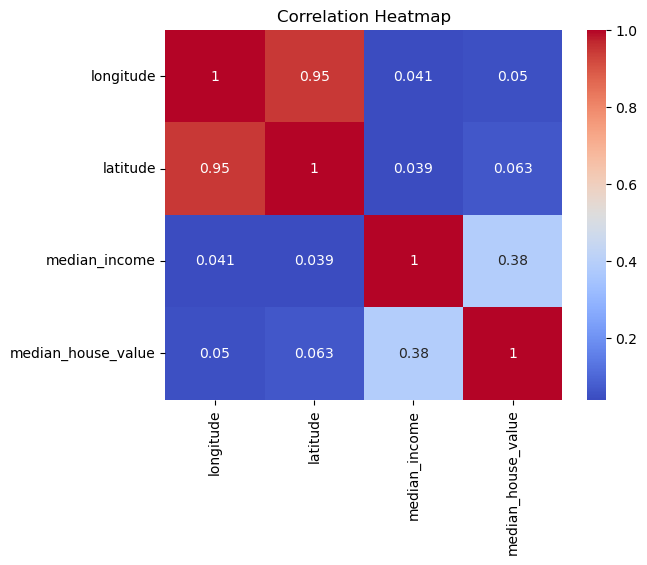

In [324]:
sns.heatmap(df.select_dtypes('number').corr().abs(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [325]:
df.nunique()

longitude              621
latitude               557
median_income         4363
median_house_value    1398
dtype: int64

######  Create X_train matrix and Y_train target

In [228]:
features = ["longitude", "latitude", "median_income"]
target = "median_house_value"
X_train = df[features]
y_train = df[target]

###### Baseline prediction and MAE for baseline

In [236]:
y_mean = round(y_train.mean(), 2)
y_baseline_pred = [y_mean]*len(y_train)
print("mean apt price", y_mean)
print("Mean Absolute Error", mean_absolute_error(y_train, y_baseline_pred).round(2))

mean apt price 180644.22
Mean Absolute Error 33132.31


###### Initializing model

In [239]:
model = make_pipeline(
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

###### Training the model and Calcuating Mean Absolute Error

In [252]:
y_train_pred = model.predict(X_train)
print("MAE", mean_absolute_error(y_train, y_train_pred).round(2))

MAE 27424.13


###### COMMUNICATING RESULT

###### 1. USING VISUALIZATION (Open Street Map)

In [272]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="latitude",
    lon="longitude",
    center={"lat": 36.778259, "lon": -119.417931},  # Map will be centered on California City
    width=600,  # Width of map
    height=600,  # Height of map
    hover_data=["median_house_value"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

median_house_value tends to go higher along the coastline

###### 2. USING EQUATION

In [271]:
intercept = model["ridge"].intercept_
coefficient = model["ridge"].coef_
print(
    f"median_house_value = {intercept} + (lon * {coefficient[0]}) + (lat * {coefficient[1]}) + (income * {coefficient[2]})"
)

median_house_value = -1712493.2181856383 + (lon * -21577.777279022106) + (lat * -20893.375329092443) + (income * 15011.183188591067)


###### 3. USING DEPLOYMENT FUNCTION

In [321]:
def make_prediction(longitude, latitude, median_income):
    data = {
        "longitude":longitude,
        "latitude":latitude,
        "median_income":median_income
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"price = ${prediction}"
    

###### Test if model can generalize

In [322]:
make_prediction(-34.60, -58.46, 6.9)

'price = $359101.76'

###### 3. USING INTERACTIVE DASH BOARD 

In [323]:
interact(
    make_prediction,
    latitude=FloatSlider(
        min=X_train["latitude"].min(),
        max=X_train["latitude"].max(),
        step=0.01,
        value=X_train["latitude"].mean(),
    ),
    longitude=FloatSlider(
        min=X_train["longitude"].min(),
        max=X_train["longitude"].max(),
        step=0.01,
        value=X_train["longitude"].mean(),
    ),
     median_income=FloatSlider(
        min=X_train["median_income"].min(),
        max=X_train["median_income"].max(),
        value=X_train["median_income"].mean(),
     )
);

interactive(children=(FloatSlider(value=-119.20641768797543, description='longitude', max=-115.4, min=-124.17,…